# Understanding the IMDb Dataset

First, we'll need to set up our notebook to be able to process this data.

In [2]:
# Import necessary libraries and packages
import pandas as pd
import numpy as np
import sqlite3
import zipfile
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Extract IMDb SQL .db file
with zipfile.ZipFile('../../data/im.db.zip') as zipObj:
    # Extract all contents of .zip file into current directory
    zipObj.extractall(path='../../data/')
    
# Connect to IMDB DB and get schema
con = sqlite3.connect('../../data/im.db')

Let's take a look at what this dataset actually *contains*.

In [17]:
pd.read_sql("""

SELECT *
FROM sqlite_master

""",con);

For starters, let's take a look at the ```movie_basics``` and ```movie_ratings``` tables.

In [33]:
basics_query = """SELECT * FROM movie_basics"""

pd.read_sql(basics_query,con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


146,144 entries - that's a **lot** of movies!

We have a few columns with null values: ```original_title```, ```runtime_minutes```, and ```genres```. We'll have to figure out how to deal with those in due time, but first, let's get a closer look at what's actually contained in the table.

In [35]:
pd.read_sql(basics_query,con).head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


Since the majority of movies in the dataset have the same `primary_title` and `original_title`, and since `primary_title` is often the English-translated title, we can probably drop `original_title` when we join these tables.

We also have a primary key: `movie_id`.

Okay, what about the table `movie_ratings`?

In [39]:
ratings_query = """SELECT * FROM movie_ratings"""

pd.read_sql(ratings_query,con).head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


That table is easy enough to read, but it only gives us **alphanumeric values** to identify what movie is associated with a given row's `averagerating` and `numvotes`. We will address that when we join the tables.

Let's take a more bird's-eye view of the `movie_ratings` table using `.info()`.

In [41]:
pd.read_sql(ratings_query,con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


No null values in any of the three columns! But `movie_ratings`, with 73,856 rows, has only *half* as many entries as `movie_basics` - that means there are a lot of entries in `movie_basics` without an associated rating!

The two tables have `movie_id` in common, so we'll join them on that column.

Which column should we investigate first in order to get a sense of what movies (and what kinds of movies) are popular: `averagerating` or `numvotes`?

`averagerating` will provide us an idea of what *scores* IMDb users have assigned a movie" (i.e. users' *evaluations* of a movie's quality), but `num_votes` tells us *how many* IMDb users have rated the movie, which likely gives us a better idea of a movie's **reach**.

In [19]:
sample_df = pd.read_sql("""
    SELECT
        -- Importing columns from movie_basics
        mb.primary_title AS "Title",
        mb.start_year AS "Release Year",
        -- Importing columns from movie_ratings
        mr.averagerating AS "Avg. Rating",
        mr.numvotes AS "# of Ratings"
    FROM
        movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
    WHERE
        -- Looking at movies only from 2010-2019 (most recent
        -- year in dataset)
        mb.start_year >= 2010
    ORDER BY
        mr.numvotes DESC
""",con)

print(sample_df['# of Ratings'].mean())
print(sample_df['# of Ratings'].median())

ratings.describe().apply(lambda x: format(x, 'f'))

3523.6621669194105
49.0


count      73856.000000
mean        3523.662167
std        30294.022971
min            5.000000
25%           14.000000
50%           49.000000
75%          282.000000
max      1841066.000000
Name: # of Ratings, dtype: object

The function to convert the output of `ratings.describe()` from scientific notation to the above notation was provided by [Ash Upadhyay](https://stackoverflow.com/posts/47207283/revisions).

It's looking like we'll need to merge the two tables on `key movie_id`, otherwise we won't be able to identify what movie each cell in `averagerating` *actually correspond to!*

In [31]:
imdb_df_sample = pd.read_sql("""
    SELECT
        -- Importing columns from movie_basics
        mb.primary_title AS "Title",
        mb.start_year AS "Release Year",
        mb.genres AS "genres",
        mb.runtime_minutes AS "Runtime",
        -- Importing columns from movie_ratings
        mr.averagerating AS "Avg. Rating",
        mr.numvotes AS "# of Ratings"
    FROM
        movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
    WHERE
        -- Looking at movies only with more than 200,000
        -- user ratings
        mr.numvotes >= 200000 AND
        -- Looking at movies only from 2010-2019 (most recent
        -- year in dataset)
        mb.start_year >= 2010
    ORDER BY
        mr.averagerating DESC
""",con)

print(f"There are {imdb_df_sample.shape[0]} movies on IMDb with >= 200,000 user ratings on IMDb.")

# Database column 'genres' gives us multiple genres separated
# by commas -- using split() to create a LIST of genres
imdb_df_sample['genres'] = imdb_df_sample['genres'].str.split(',')

There are 304 movies on IMDb with >= 200,000 user ratings on IMDb.


In [11]:
# Let's look at the 10 best rated movies by users
imdb_df_sample.head(10)

,Title,Release Year,genres,Runtime,Avg. Rating,# of Ratings
0,Inception,2010,"[Action, Adventure, Sci-Fi]",148.0,8.8,1841066
1,Avengers: Endgame,2019,"[Action, Adventure, Sci-Fi]",181.0,8.8,441135
2,Interstellar,2014,"[Adventure, Drama, Sci-Fi]",169.0,8.6,1299334
3,The Intouchables,2011,"[Biography, Comedy, Drama]",112.0,8.5,677343
4,Whiplash,2014,"[Drama, Music]",106.0,8.5,616916
5,Avengers: Infinity War,2018,"[Action, Adventure, Sci-Fi]",149.0,8.5,670926
6,Spider-Man: Into the Spider-Verse,2018,"[Action, Adventure, Animation]",117.0,8.5,210869
7,The Dark Knight Rises,2012,"[Action, Thriller]",164.0,8.4,1387769
8,Django Unchained,2012,"[Drama, Western]",165.0,8.4,1211405
9,Coco,2017,"[Adventure, Animation, Comedy]",105.0,8.4,277194


It looks like we have a pretty wide range of runtimes, and several of the movies with the highest average ratings on the site clock in at **over 2.5 hours!** Given the lack of correlation between a movie's runtime and its performance with critics we observed in the RottenTomatoes data, we can safely drop ```runtime_minutes``` / ```Runtime``` and focus on the other columns instead.

In [12]:
imdb_df_sample.drop(columns=['Runtime'], inplace=True)

In [13]:
# Now let's zoom in on the genres of the whole set
imdb_df_sample['genres']

0      [Action, Adventure, Sci-Fi]
1      [Action, Adventure, Sci-Fi]
2       [Adventure, Drama, Sci-Fi]
3       [Biography, Comedy, Drama]
4                   [Drama, Music]
                  ...             
299    [Action, Adventure, Sci-Fi]
300    [Adventure, Drama, Fantasy]
301    [Adventure, Drama, Fantasy]
302    [Adventure, Drama, Fantasy]
303     [Drama, Romance, Thriller]
Name: genres, Length: 304, dtype: object

Looks like the ```genres``` column has a *list* of genres for each entry. We're going to need to split those lists up in order to get accurate value counts for each genre. (Credit for this function goes to [Max Hilsdorf](https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173).)

In [27]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

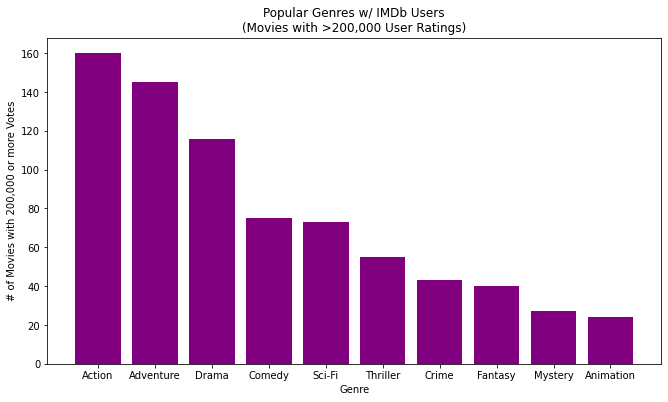

In [15]:
# Top ten most frequently occurring genres
top_genres = to_1D(imdb_df_sample['genres']).value_counts().head(10)

# Plotting top ten genres
genres_fig, ax = plt.subplots(figsize = (11, 6))

ax.bar(x=top_genres.index,
       height=top_genres,
       color='purple')
ax.set_title("""Popular Genres w/ IMDb Users, 2010-2019
(Movies with >200,000 User Ratings)""")
ax.set_xlabel("Genre")
ax.set_ylabel("# of Movies with 200,000 or more Votes");

Interesting. ```Action``` and ```Adventure``` movies make up a significant share

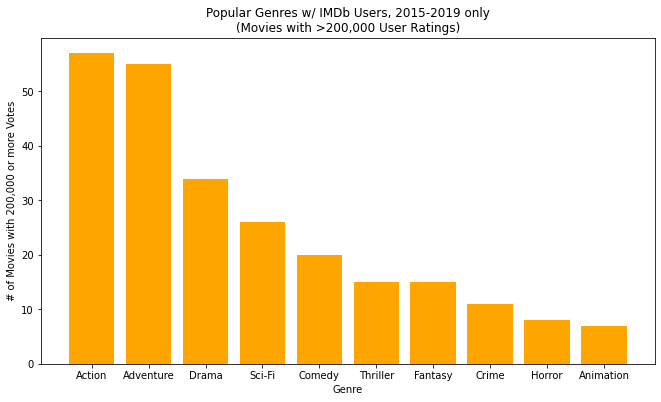

In [16]:
# Obtaining a dataframe of only movies released 2015-2019
late_decade_df = imdb_df_sample[imdb_df_sample['Release Year'] >= 2015]

# Creating another list of top ten genres
genres2 = to_1D(late_decade_df['genres']).value_counts().head(10)

# Creating a second graph
genres_fig, ax = plt.subplots(figsize = (11, 6))

ax.bar(x=genres2.index,
       height=genres2,
       color='orange')
ax.set_title("""Popular Genres w/ IMDb Users, 2015-2019 only
(Movies with >200,000 User Ratings)""")
ax.set_xlabel("Genre")
ax.set_ylabel("# of Movies with 200,000 or more Votes");

These graphs are pretty comparable, both in their shapes and in their distributions of genres. We can observe an uptick in the popularity of **sci-fi films** in the latter half of the 2010s, as the data

# Working code

(The function to convert the output of ```ratings.describe()``` from scientific notation to the below notation was provided by [Ash Upadhyay](https://stackoverflow.com/posts/47207283/revisions).)

In [32]:
sample_df = pd.read_sql("""
    SELECT
        -- Importing columns from movie_basics
        mb.primary_title AS "Title",
        mb.start_year AS "Release Year",
        -- Importing columns from movie_ratings
        mr.averagerating AS "Avg. Rating",
        mr.numvotes AS "# of Ratings"
    FROM
        movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
    WHERE
        -- Looking at movies only from 2010-2019 (most recent
        -- year in dataset)
        mb.start_year >= 2010
    ORDER BY
        mr.numvotes DESC
""",con)

ratings.describe().apply(lambda x: format(x, 'f'))

count      73856.000000
mean        3523.662167
std        30294.022971
min            5.000000
25%           14.000000
50%           49.000000
75%          282.000000
max      1841066.000000
Name: # of Ratings, dtype: object

Wow... not only is our ```mean``` well above the ```50%``` value (the median), but it's **more than ten times larger** than the ```75%``` value!

In [26]:
# Trying to figure out what to do with directors
# and persons
pd.read_sql("""
    SELECT
        prsn.primary_name AS "Name",
        COUNT() AS "Number of Movies"
    FROM
        persons AS prsn
        JOIN directors AS drs
            on prsn.person_id = drs.person_id
    GROUP BY
        "Name"
    ORDER BY
        "Number of Movies" DESC
""",con);